In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import logging
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from rdkit import Chem
from rdkit.Chem import AllChem

/home/elias/Dev/fac/taiwan/deeplearning/finalproject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
logger.info("Loading and preprocessing data...")
df = pd.read_csv('GDSC_DATASET.csv')

if 'SMILES' not in df.columns or df['SMILES'].isnull().any():
    logger.info("SMILES column not found or has nulls, loading from smiles_cache.pkl...")
    if os.path.exists('smiles_cache.pkl'):
        with open('smiles_cache.pkl', 'rb') as f:
            smiles_map = pickle.load(f)
        df['SMILES'] = df['DRUG_NAME'].map(smiles_map)
    else:
        raise FileNotFoundError('smiles_cache.pkl not found. Please run dualtower.ipynb first.')

df = df.dropna(subset=['SMILES', 'LN_IC50'])
df = df.drop_duplicates(subset=['DRUG_NAME', 'CELL_LINE_NAME'])
logger.info(f'Dataset size after cleaning: {len(df)}')

2025-12-17 21:37:14,896 - INFO - Loading and preprocessing data...
2025-12-17 21:37:15,209 - INFO - SMILES column not found or has nulls, loading from smiles_cache.pkl...
2025-12-17 21:37:15,279 - INFO - Dataset size after cleaning: 193951


In [4]:
CELL_FEATURES = [
    'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2', 'TCGA_DESC',
    'Microsatellite instability Status (MSI)', 'Growth Properties', 'CNA',
    'Gene Expression', 'Methylation'
]

class CellFeatureEncoder:
    def __init__(self):
        self.encoders = {col: LabelEncoder() for col in CELL_FEATURES}
        self.scaler = StandardScaler()

    def fit_transform(self, df_input):
        encoded_features = []
        for col in CELL_FEATURES:
            if col in df_input:
                col_data = df_input[col].fillna('Unknown').astype(str)
                encoded_features.append(self.encoders[col].fit_transform(col_data).reshape(-1, 1))
        if not encoded_features:
            raise ValueError('No cell features found.')
        X_cell_raw = np.hstack(encoded_features)
        return self.scaler.fit_transform(X_cell_raw)

cell_encoder = CellFeatureEncoder()
X_cell = cell_encoder.fit_transform(df)

In [5]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic(),
            atom.GetNumRadicalElectrons()
        ])
    x = torch.tensor(atom_features, dtype=torch.float)

    # Edge features
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([(i, j), (j, i)])
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

X_drug = [smiles_to_graph(s) for s in df['SMILES']]
# Filter out None graphs
valid_indices = [i for i, g in enumerate(X_drug) if g is not None]
X_drug = [X_drug[i] for i in valid_indices]
X_cell = X_cell[valid_indices]
y = df['LN_IC50'].values[valid_indices].astype(np.float32)

In [6]:
class DrugResponseDataset(Dataset):
    def __init__(self, cell_features, drug_graphs, labels):
        self.cell_features = torch.tensor(cell_features, dtype=torch.float32)
        self.drug_graphs = drug_graphs
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.cell_features[idx], self.drug_graphs[idx], self.labels[idx]

In [7]:
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNModel(nn.Module):
    def __init__(self, cell_input_dim, gnn_hidden_dim=64, gnn_out_dim=64, num_gnn_layers=3):
        super(GNNModel, self).__init__()

        # Cell Tower
        self.cell_tower = nn.Sequential(
            nn.Linear(cell_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # GNN Tower
        self.gnn_convs = nn.ModuleList()
        self.gnn_convs.append(GCNConv(X_drug[0].num_node_features, gnn_hidden_dim))
        for _ in range(num_gnn_layers - 1):
            self.gnn_convs.append(GCNConv(gnn_hidden_dim, gnn_hidden_dim))

        self.gnn_out = nn.Linear(gnn_hidden_dim, gnn_out_dim)


        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(64 + gnn_out_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, cell_data, drug_data):
        # Cell tower forward pass
        cell_x = self.cell_tower(cell_data)

        # GNN tower forward pass
        x, edge_index, batch = drug_data.x, drug_data.edge_index, drug_data.batch
        for conv in self.gnn_convs:
            x = conv(x, edge_index)
            x = x.relu()
        
        x = global_mean_pool(x, batch)
        drug_x = self.gnn_out(x)

        # Fusion
        concat = torch.cat([cell_x, drug_x], dim=1)
        out = self.fusion(concat)
        return out.squeeze(1)

In [8]:
logger.info("Splitting data and building model...")

# We need to handle the split carefully as X_drug is a list of graphs
X_cell_train, X_cell_val, X_drug_train, X_drug_val, y_train, y_val = train_test_split(
    X_cell, X_drug, y, test_size=0.2, random_state=42
)

train_dataset = DrugResponseDataset(X_cell_train, X_drug_train, y_train)
val_dataset = DrugResponseDataset(X_cell_val, X_drug_val, y_val)

# Custom collate_fn for handling PyG Data objects
def collate_fn(batch):
    cell_features = torch.stack([item[0] for item in batch])
    drug_graphs = Batch.from_data_list([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return cell_features, drug_graphs, labels

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

model = GNNModel(
    cell_input_dim=X_cell.shape[1]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Added weight decay
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

print(model)

2025-12-17 21:38:40,542 - INFO - Splitting data and building model...
2025-12-17 21:38:40,607 - INFO - Using device: cuda


GNNModel(
  (cell_tower): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (gnn_convs): ModuleList(
    (0): GCNConv(6, 64)
    (1-2): 2 x GCNConv(64, 64)
  )
  (gnn_out): Linear(in_features=64, out_features=64, bias=True)
  (fusion): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
logger.info("Starting model training...")
train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 10
num_epochs = 50 

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for cell, drug, labels in train_loader:
        cell, drug, labels = cell.to(device), drug.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(cell, drug)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for cell, drug, labels in val_loader:
            cell, drug, labels = cell.to(device), drug.to(device), labels.to(device)
            outputs = model(cell, drug)
            val_loss += criterion(outputs, labels).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)

    logger.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        logger.info("Validation loss improved, saving model.")
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        logger.info(f'Early stopping triggered after {epoch + 1} epochs.')
        break

logger.info("Loading best model for evaluation...")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_pred_list = []
y_val_list = []
with torch.no_grad():
    for cell, drug, labels in val_loader:
        cell, drug, labels = cell.to(device), drug.to(device), labels.to(device)
        outputs = model(cell, drug)
        y_pred_list.append(outputs.cpu().numpy())
        y_val_list.append(labels.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_val_eval = np.concatenate(y_val_list)

mse = mean_squared_error(y_val_eval, y_pred)
r2 = r2_score(y_val_eval, y_pred)
logger.info(f'Test MSE: {mse:.4f}')
logger.info(f'Test R2: {r2:.4f}')

2025-12-17 20:03:28,716 - INFO - Plotting results...


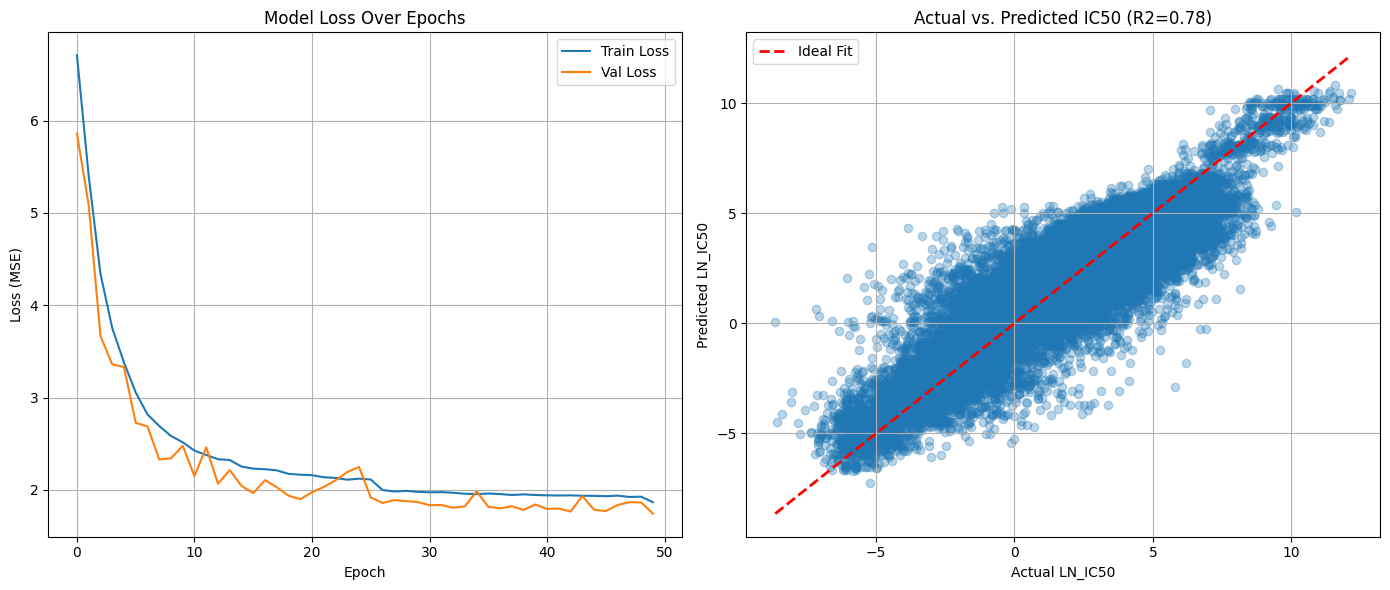

2025-12-17 20:03:29,662 - INFO - Script finished successfully.


In [ ]:
logger.info("Plotting results...")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_val_eval, y_pred, alpha=0.3)
plt.plot([y_val_eval.min(), y_val_eval.max()], [y_val_eval.min(), y_val_eval.max()], 'r--', lw=2, label='Ideal Fit')
plt.title(f'Actual vs. Predicted IC50 (R2={r2:.2f})')
plt.xlabel('Actual LN_IC50')
plt.ylabel('Predicted LN_IC50')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('gnn_results.png')
plt.show()

logger.info("Script finished successfully.")
